# Introduction to Problem of Brain Tumor

A brain tumor is one of the most dangerous diseases that can affect both children and adults. The majority of primary Central Nervous System (CNS) tumors are brain tumors, which account for 85 to 90% of all cases. Around 11,700 people are diagnosed with a brain tumor each year. People with a cancerous brain or CNS tumor have a 5-year survival rate of approximately 34% for men and 36% for women. Glioma Tumors, Meningioma Tumors, Pituitary Tumors, and other types of brain tumors are classified. To increase the patients' life expectancy, proper treatment, planning, and accurate diagnostics should be implemented. Magnetic Resonance Imaging (MRI) is the most effective method for detecting brain tumors. The scans generate a tremendous amount of image data. The radiologist inspects these photographs. Because of the complexity involved in brain tumors and their properties, a manual examination can be prone to errors.

# Objective

Deep learning is being used to forecast a variety of brain tumor. The major objectives of this notebook are to attain a high level of brain tumor prediction accuracy. Deep learning approaches assist in the early diagnosis of brain tumor. The classification of brain tumor relies heavily on feature extraction. Human labor, such as manual feature extraction and data reconstruction for classification purposes, is reduced when Deep Learning algorithms are used. As a result, proposing a system that uses Deep Learning Algorithms using Convolution Neural Network (CNN) and Transfer Learning (TL) to do classification will be beneficial to doctors all over the world.

# Description of the Brain tumor Dataset

The dataset is organized into 2 folders (Training, Testing) and contains 4 subfolders for each image category. There are 3,264 MRI images (JPEG) and 4 categories (Glioma/Meningioma/Pituitary/No_tumor).
1. Training set
* Glioma tumor (826 images)
* Meningioma tumor (822 images)
* No tumor (395 images)
* Pituitary tumor (827 images)
2. Testing set
* Glioma tumor (100 images)
* Meningioma tumor (115 images)
* No tumor (105 images)
* Pituitary tumor (74 images)

# Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization

# Data Preperation

Appending all the images from the directories into a list and then converting them into numpy arrays after resizing it.

In [2]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 74/74 [00:00<00:00, 84.83it/s]


**Previewing the images in each classes**

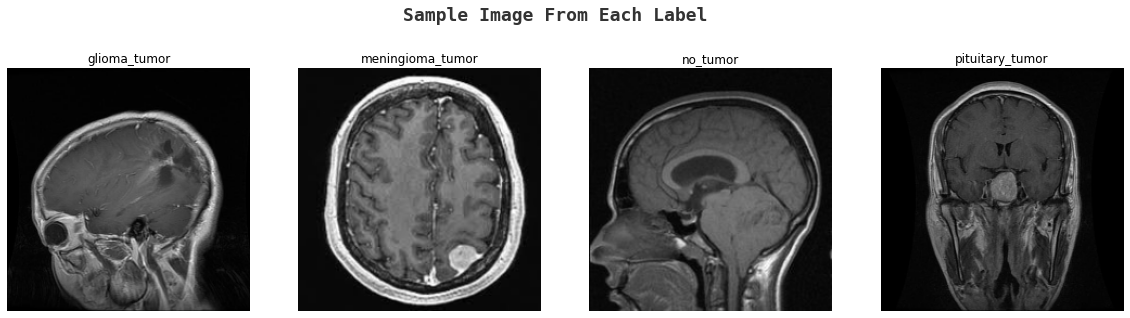

In [3]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

**Shuffle the train set**

In [4]:
X_train, y_train = shuffle(X_train,y_train, random_state=14)

**Print out train set shape**

In [5]:
X_train.shape

(2870, 224, 224, 3)

**Print out test set shape**

In [6]:
X_test.shape

(394, 224, 224, 3)

**Show the counts of observations in each categorical**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

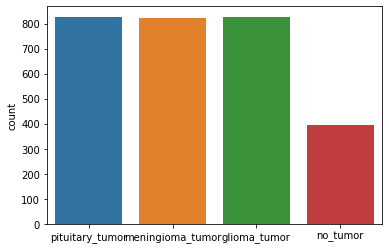

In [7]:
sns.countplot(y_train)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

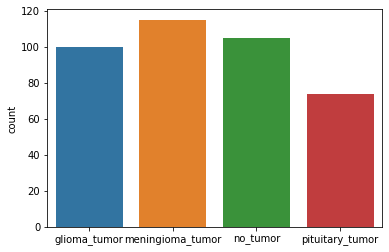

In [8]:
sns.countplot(y_test)

**Performing One Hot Encoding on the labels after converting it into numerical values**

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**Dividing the dataset into Training and Testing sets.**

In [10]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=14)

**Normalize the data**

In [11]:
X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.
X_test = np.array(X_test) / 255.

**Data Augmentation**


To prevent the problem of overfitting, we can artificially enlarge the dataset. I can increase the size of the current dataset. The idea is to alter the training data with small transformations to reproduce the variations.   Data augmentation strategies are methods for changing the array representation while keeping the label the same while altering the training data. Grayscales, horizontal and vertical flips, random crops, color jitters, translations, rotations, and many other augmentations are popular. I can easily double or increase the number of training examples by applying only a couple of these changes to the training data.

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

For the data augmentation, i choosed to :
1.   Randomly rotate some training images by 10 degrees.
2.   Randomly Zoom by 10% some training images.
3.   Randomly shift images horizontally by 10% of the width.
4.   Randomly shift images vertically by 10% of the height.
5.   Randomly flip images horizontally.

**Callback function**


Callbacks can help fix bugs more quickly, and can help build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.

By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using TensorBoard, ModelCheckpoint and ReduceLROnPlateau callback functions

In [13]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

2022-01-24 14:31:15.609263: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-24 14:31:15.609322: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-24 14:31:15.648822: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-01-24 14:31:15.681530: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-24 14:31:15.681722: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


# Detail of model implementation

**CNN approach**

In [14]:
model_cnn = Sequential()

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization()) 

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35)) 

model_cnn.add(Conv2D(64, (3, 3), padding='same')) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten()) 
model_cnn.add(Dropout(0.5)) 
model_cnn.add(Dense(512)) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4)) 
model_cnn.add(Activation('softmax'))

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 111, 111, 64)      2

2022-01-24 14:31:16.692102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 14:31:16.790583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 14:31:16.791279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 14:31:16.792255: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

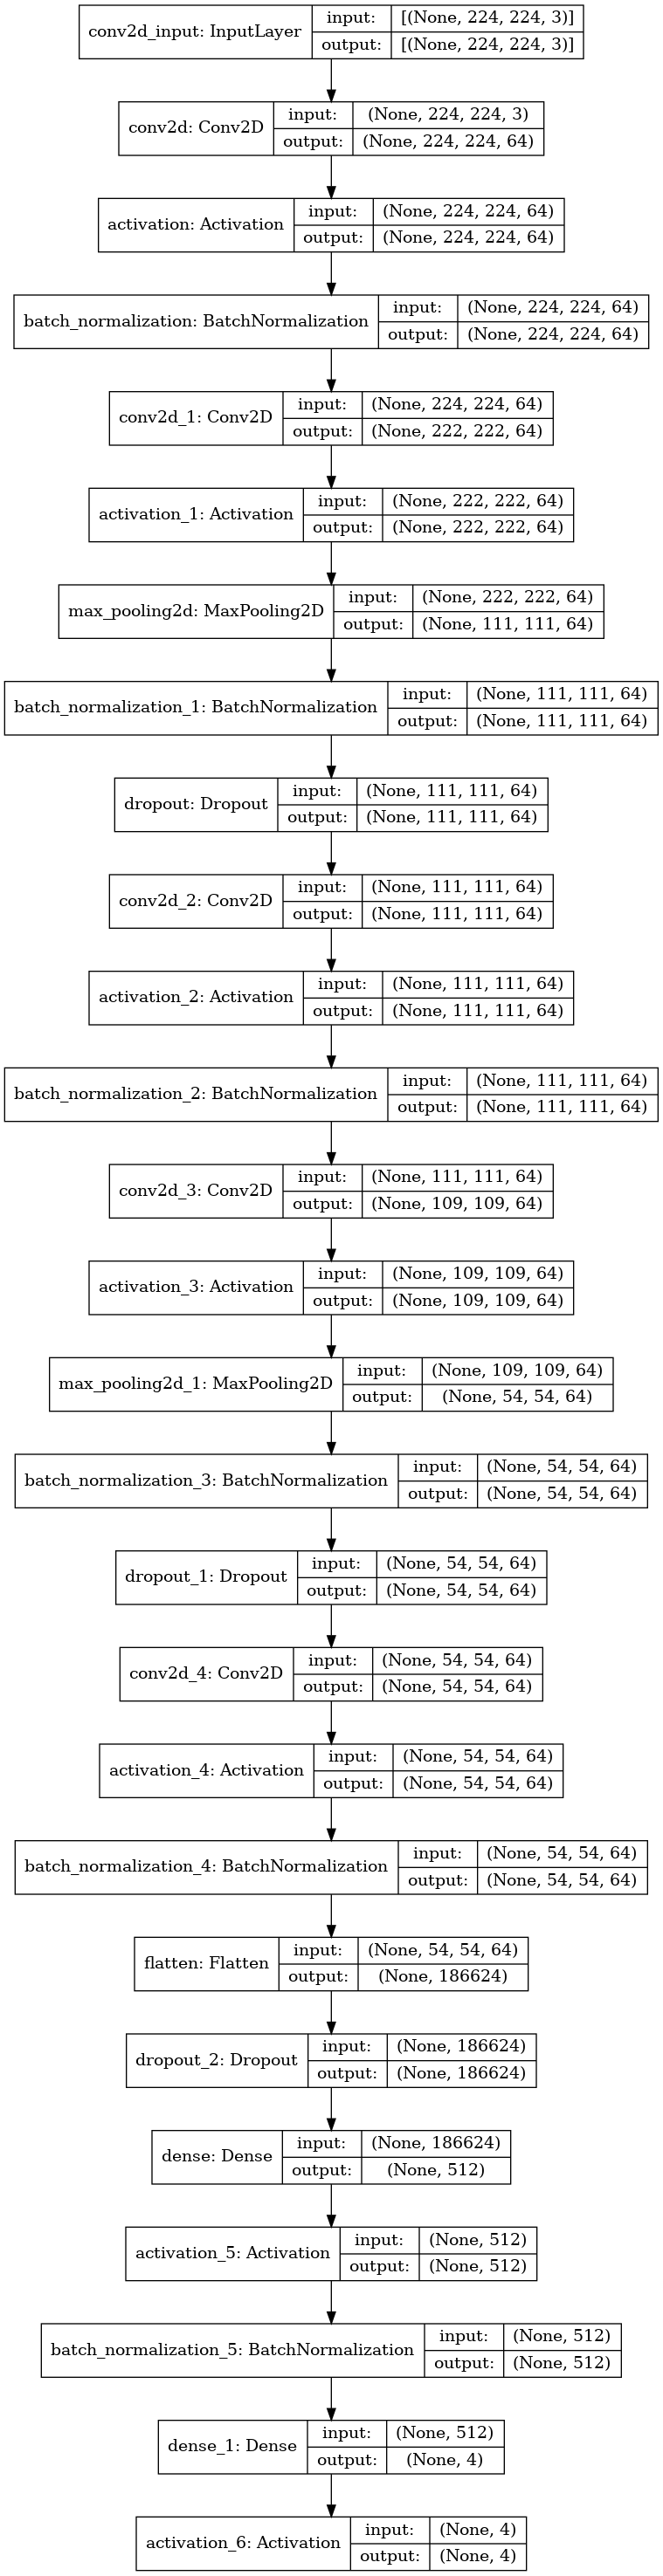

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [17]:
history = model_cnn.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

2022-01-24 14:31:21.506153: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1399308288 exceeds 10% of free system memory.
2022-01-24 14:31:22.918432: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1399308288 exceeds 10% of free system memory.
2022-01-24 14:31:23.954684: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-01-24 14:31:25.906918: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/73 [..............................] - ETA: 10:16 - loss: 1.8950 - accuracy: 0.2500

2022-01-24 14:31:32.590081: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-24 14:31:32.590132: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/73 [..............................] - ETA: 32s - loss: 3.2564 - accuracy: 0.3438  

2022-01-24 14:31:33.026228: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-24 14:31:33.027229: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-24 14:31:33.162224: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 259 callback api events and 256 activity events. 
2022-01-24 14:31:33.170298: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-24 14:31:33.187263: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_01_24_14_31_33

2022-01-24 14:31:33.193893: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_01_24_14_31_33/00d43386f419.trace.json.gz
2022-01-24 14:31:33.219554: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

73/73 [==============================] - 20s 152ms/step - loss: 1.1227 - accuracy: 0.6906 - val_loss: 14.0662 - val_accuracy: 0.2973

Epoch 00001: val_accuracy improved from -inf to 0.29730, saving model to effnet.h5
Epoch 2/20
73/73 [==============================] - 9s 120ms/step - loss: 0.4461 - accuracy: 0.8343 - val_loss: 10.6823 - val_accuracy: 0.2973

Epoch 00002: val_accuracy did not improve from 0.29730
Epoch 3/20
73/73 [==============================] - 9s 119ms/step - loss: 0.2940 - accuracy: 0.8916 - val_loss: 5.3595 - val_accuracy: 0.3205

Epoch 00003: val_accuracy improved from 0.29730 to 0.32046, saving model to effnet.h5
Epoch 4/20
73/73 [==============================] - 9s 120ms/step - loss: 0.2240 - accuracy: 0.9152 - val_loss: 4.7946 - val_accuracy: 0.3514

Epoch 00004: val_accuracy improved from 0.32046 to 0.35135, saving model to effnet.h5
Epoch 5/20
73/73 [==============================] - 9s 120ms/step - loss: 0.1678 - accuracy: 0.9441 - val_loss: 4.8071 - val_a

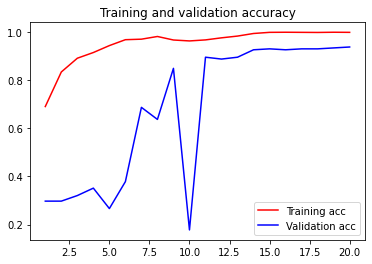

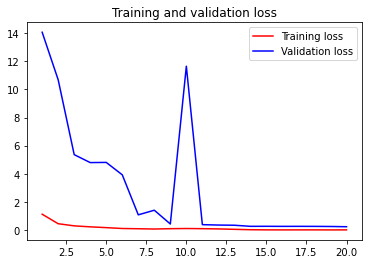

In [18]:
model_cnn.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

I've used the argmax function as each row from the prediction array contains four values for the respective labels. The maximum value which is in each row depicts the predicted output out of the 4 possible outcomes.
So with argmax, I'm able to find out the index associated with the predicted outcome.

In [19]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [20]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 73.35%


**Evaluation**

In [21]:
model_cnn.evaluate(X_train, y_train)

2022-01-24 14:36:03.094640: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1555255296 exceeds 10% of free system memory.
2022-01-24 14:36:04.743867: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1555255296 exceeds 10% of free system memory.


81/81 [==============================] - 3s 41ms/step - loss: 0.0239 - accuracy: 0.9938


[0.023942632600665092, 0.9938056468963623]

In this,

*   0 - Glioma Tumor
*   1 - Meningioma Tumor
*   2 - No Tumor
*   3 - Pituitary Tumo

In [22]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.76      0.16      0.26       100
           1       0.76      0.95      0.84       115
           2       0.65      0.99      0.78       105
           3       0.87      0.81      0.84        74

    accuracy                           0.73       394
   macro avg       0.76      0.73      0.68       394
weighted avg       0.75      0.73      0.68       394



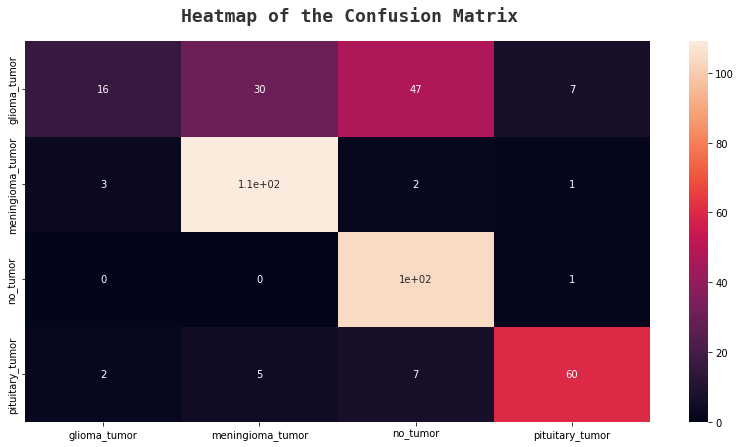

In [23]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**Transfer learning approach**

Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task. In this project I use pretrained models like VGG-16 and EfficientNetB0. Which is trained on large ImageNet dataset.

The ImageNet project is a large visual database designed for use in visual object recognition software research. More than 14 million images have been hand-annotated by the project to indicate what objects are pictured and in at least one million of the images, bounding boxes are also provided. ImageNet contains more than 20,000 categories with a typical category, such as "balloon" or "strawberry", consisting of several hundred images.

**VGG16**

The include_top parameter is set to False so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [24]:
vgg=VGG16(input_shape=(image_size,image_size,3) , weights='imagenet' , include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [25]:
for layers in vgg.layers:
  layers.trainable=False

In [26]:
model_vgg = vgg.output
model_vgg = GlobalAveragePooling2D()(model_vgg)
model_vgg = Dense(128,activation='relu')(model_vgg)
model_vgg = Dropout(0.15)(model_vgg)
model_vgg = Dense(4,activation='softmax')(model_vgg)
model_vgg = Model(inputs=vgg.input,outputs=model_vgg)
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

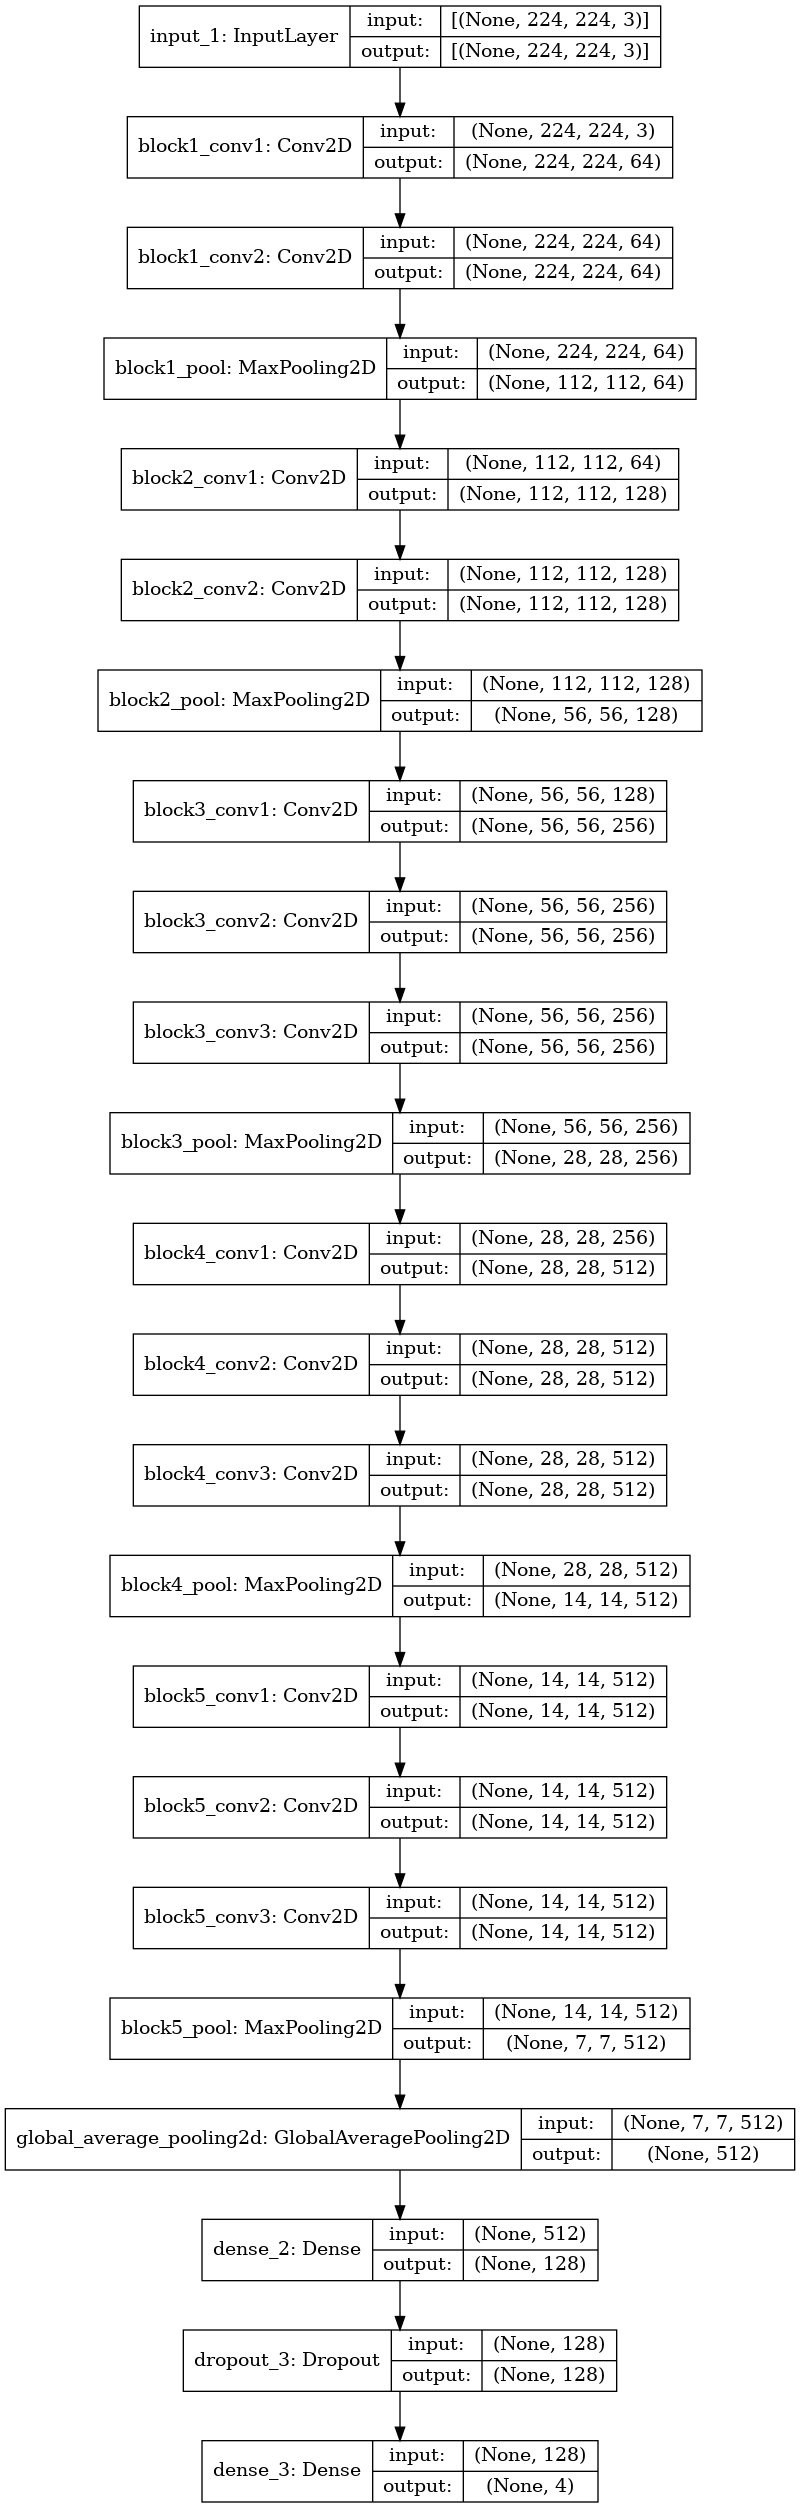

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(model_vgg, to_file='model_vgg_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
model_vgg.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [29]:
history = model_vgg.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

2022-01-24 14:36:25.187497: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1399308288 exceeds 10% of free system memory.


Epoch 1/20
 1/73 [..............................] - ETA: 4:12 - loss: 1.3682 - accuracy: 0.4062

2022-01-24 14:36:31.209272: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-24 14:36:31.209348: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/73 [..............................] - ETA: 20s - loss: 1.4018 - accuracy: 0.3438 

2022-01-24 14:36:31.528450: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-24 14:36:31.529002: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-24 14:36:31.657699: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 142 callback api events and 139 activity events. 
2022-01-24 14:36:31.663492: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-24 14:36:31.668272: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_01_24_14_36_31

2022-01-24 14:36:31.671230: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_01_24_14_36_31/00d43386f419.trace.json.gz
2022-01-24 14:36:31.678302: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

73/73 [==============================] - 12s 118ms/step - loss: 1.1621 - accuracy: 0.4987 - val_loss: 0.9133 - val_accuracy: 0.7027

Epoch 00001: val_accuracy did not improve from 0.93822
Epoch 2/20
73/73 [==============================] - 5s 74ms/step - loss: 0.8644 - accuracy: 0.6893 - val_loss: 0.7201 - val_accuracy: 0.7413

Epoch 00002: val_accuracy did not improve from 0.93822
Epoch 3/20
73/73 [==============================] - 5s 73ms/step - loss: 0.7312 - accuracy: 0.7397 - val_loss: 0.6198 - val_accuracy: 0.8031

Epoch 00003: val_accuracy did not improve from 0.93822
Epoch 4/20
73/73 [==============================] - 5s 74ms/step - loss: 0.6450 - accuracy: 0.7702 - val_loss: 0.5423 - val_accuracy: 0.7992

Epoch 00004: val_accuracy did not improve from 0.93822
Epoch 5/20
73/73 [==============================] - 5s 74ms/step - loss: 0.5987 - accuracy: 0.7793 - val_loss: 0.4984 - val_accuracy: 0.8224

Epoch 00005: val_accuracy did not improve from 0.93822
Epoch 6/20
73/73 [======

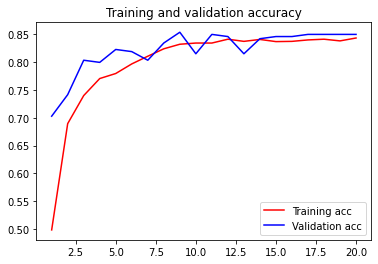

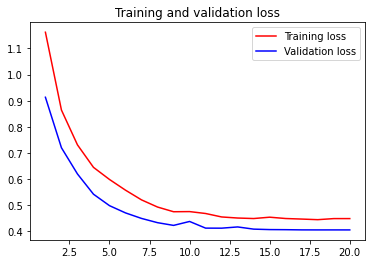

In [30]:
model_vgg.save('vgg16_model.h5')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

In [31]:
pred = model_vgg.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [32]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 53.30%


**Evaluation**

In [33]:
model_vgg.evaluate(X_train, y_train)

81/81 [==============================] - 7s 92ms/step - loss: 0.4305 - accuracy: 0.8475


[0.43053925037384033, 0.8474642038345337]

In [34]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.42      0.18      0.25       100
           1       0.53      0.59      0.56       115
           2       0.49      0.69      0.57       105
           3       0.69      0.70      0.70        74

    accuracy                           0.53       394
   macro avg       0.53      0.54      0.52       394
weighted avg       0.52      0.53      0.51       394



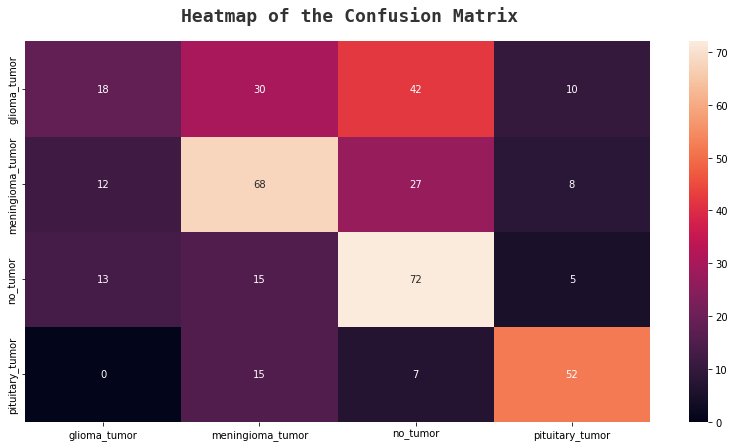

In [35]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**EfficientNetB0**

In [36]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16719872/16705208 [==============================] - 0s 0us/step


In [37]:
model_eff = effnet.output
model_eff = tf.keras.layers.GlobalAveragePooling2D()(model_eff)
model_eff = tf.keras.layers.Dropout(rate=0.5)(model_eff)
model_eff = tf.keras.layers.Dense(4,activation='softmax')(model_eff)
model_eff = tf.keras.models.Model(inputs=effnet.input, outputs = model_eff)
model_eff.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

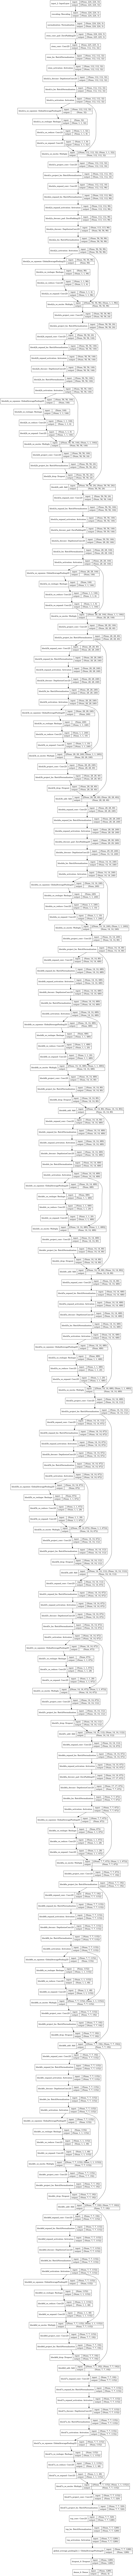

In [38]:
from keras.utils.vis_utils import plot_model
plot_model(model_eff, to_file='model_eff_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
model_eff.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [40]:
history = model_eff.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
 1/73 [..............................] - ETA: 9:52 - loss: 1.4830 - accuracy: 0.2188

2022-01-24 14:39:51.624851: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-24 14:39:51.625038: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/73 [..............................] - ETA: 51s - loss: 1.4048 - accuracy: 0.3438 

2022-01-24 14:39:52.696613: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-24 14:39:52.700333: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-24 14:39:52.856282: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2121 callback api events and 2118 activity events. 
2022-01-24 14:39:52.906753: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-24 14:39:52.966703: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_01_24_14_39_52

2022-01-24 14:39:53.000132: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_01_24_14_39_52/00d43386f419.trace.json.gz
2022-01-24 14:39:53.091758: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

73/73 [==============================] - 28s 273ms/step - loss: 0.4331 - accuracy: 0.8283 - val_loss: 2.0925 - val_accuracy: 0.1120

Epoch 00001: val_accuracy did not improve from 0.93822
Epoch 2/20
73/73 [==============================] - 16s 225ms/step - loss: 0.1727 - accuracy: 0.9423 - val_loss: 3.1935 - val_accuracy: 0.1120

Epoch 00002: val_accuracy did not improve from 0.93822
Epoch 3/20
73/73 [==============================] - 17s 226ms/step - loss: 0.0989 - accuracy: 0.9673 - val_loss: 2.9380 - val_accuracy: 0.1120

Epoch 00003: val_accuracy did not improve from 0.93822

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/20
73/73 [==============================] - 16s 223ms/step - loss: 0.0478 - accuracy: 0.9862 - val_loss: 2.9840 - val_accuracy: 0.1120

Epoch 00004: val_accuracy did not improve from 0.93822
Epoch 5/20
73/73 [==============================] - 17s 227ms/step - loss: 0.0212 - accuracy: 0.9931 - val_loss: 3.9642 - val_accuracy

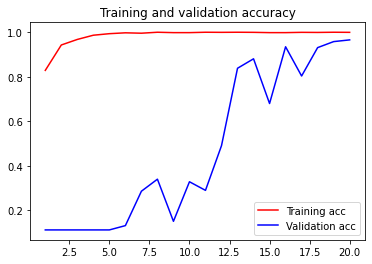

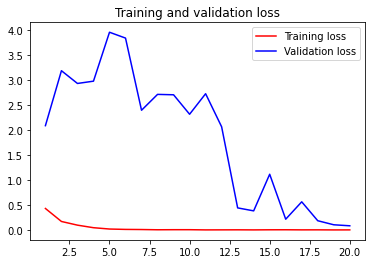

In [41]:
model_eff.save('model_eff.h5')

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

In [42]:
pred = model_eff.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [43]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 74.37%


**Evaluation**

In [44]:
model_eff.evaluate(X_train, y_train)

81/81 [==============================] - 4s 46ms/step - loss: 0.0151 - accuracy: 0.9946


[0.015088620595633984, 0.9945799708366394]

In [45]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.96      0.27      0.42       100
           1       0.72      0.97      0.82       115
           2       0.65      1.00      0.79       105
           3       1.00      0.68      0.81        74

    accuracy                           0.74       394
   macro avg       0.83      0.73      0.71       394
weighted avg       0.82      0.74      0.71       394



Text(0.28, 0.92, 'Heatmap of the Confusion Matrix')

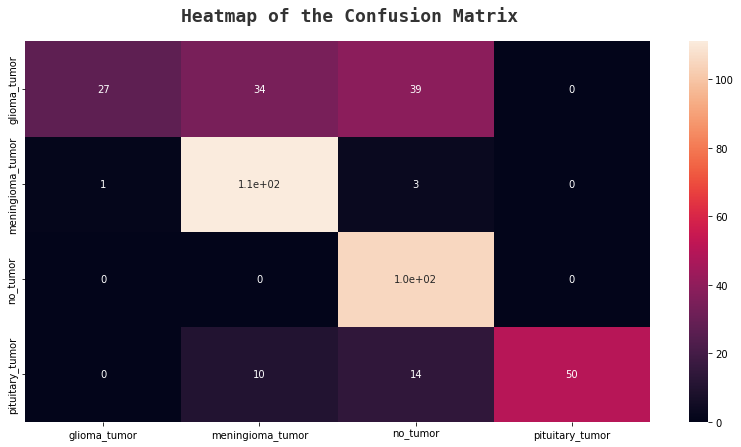

In [46]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

# Grad-CAM visualization

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

**Grad-CAM of VGG16**

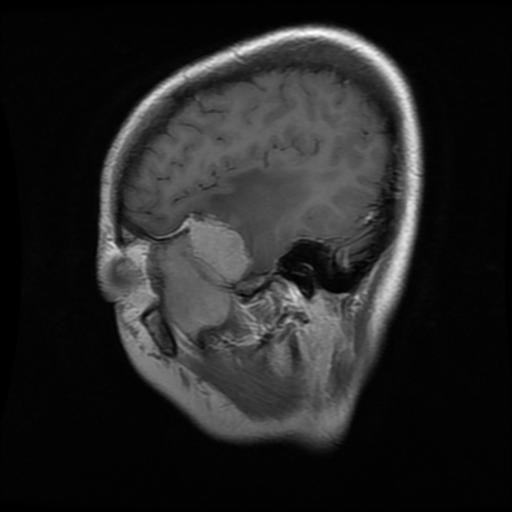

In [47]:
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm

model_builder = tf.keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path ="../input/brain-tumor-classification-mri/Training/meningioma_tumor/m3 (14).jpg"

display(Image(img_path))

In [48]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n03929660', 'pick', 10.04039)]


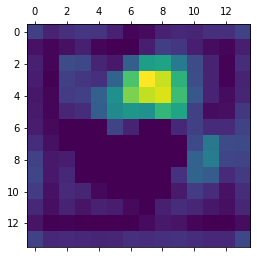

In [49]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

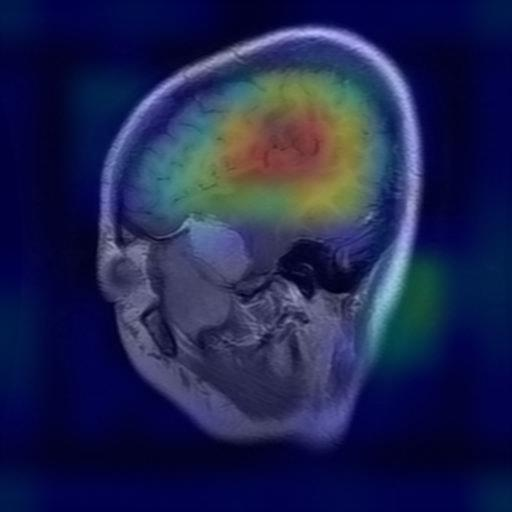

In [50]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

**Grad-CAM of EfficientNetB0**

In [51]:
model_builder = tf.keras.applications.efficientnet.EfficientNetB0
img_size = (224, 224)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"

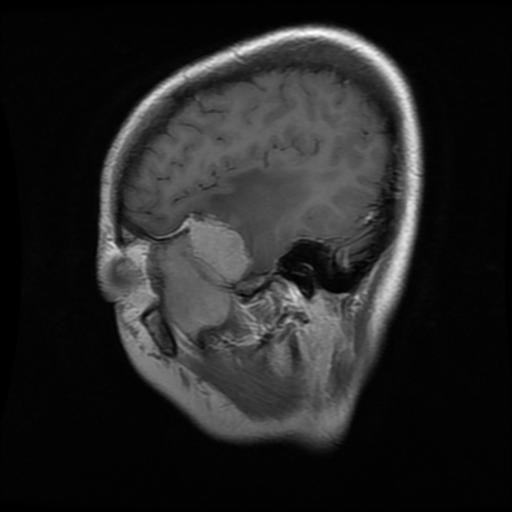

21848064/21834768 [==============================] - 0s 0us/step
Predicted: [('n01910747', 'jellyfish', 7.523436)]


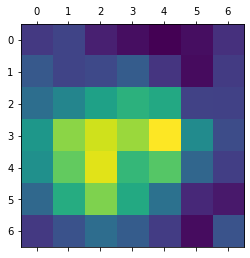

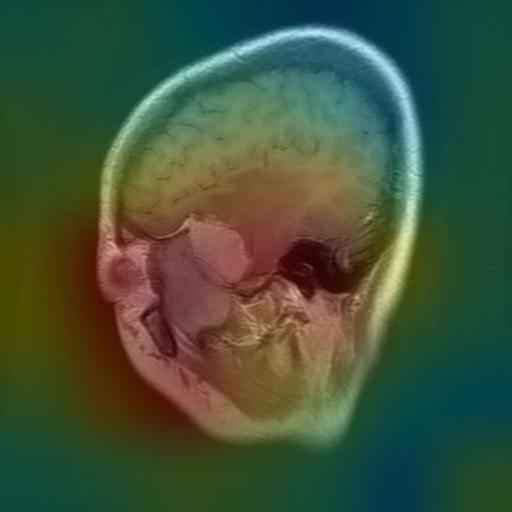

In [52]:
img_path ="../input/brain-tumor-classification-mri/Training/meningioma_tumor/m3 (14).jpg"

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)

# Experimental results

In [53]:
# Function to convert output labels to its class of tumor.
def inverse_classes(num):
    if num==0:
        return 'Glioma Tumor'
    elif num==1:
        return 'Meningioma Tumor'
    elif num==2:
        return 'No Tumor'
    else:
        return 'Pituitary Tumor'

**Prediction using CNN model**

In [54]:
train_pred = model_cnn.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 99.38%


In [55]:
test_pred = model_cnn.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 73.35%


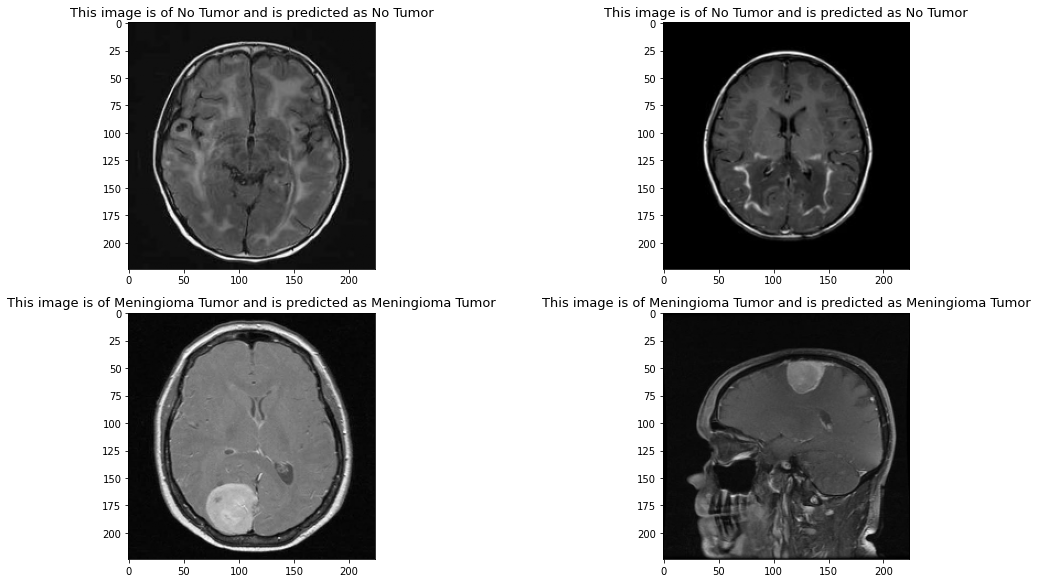

In [56]:
# Prediction using CNN model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_cnn.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

**Prediction using VGG16 model**

In [57]:
train_pred = model_vgg.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 84.75%


In [58]:
test_pred = model_vgg.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 53.30%


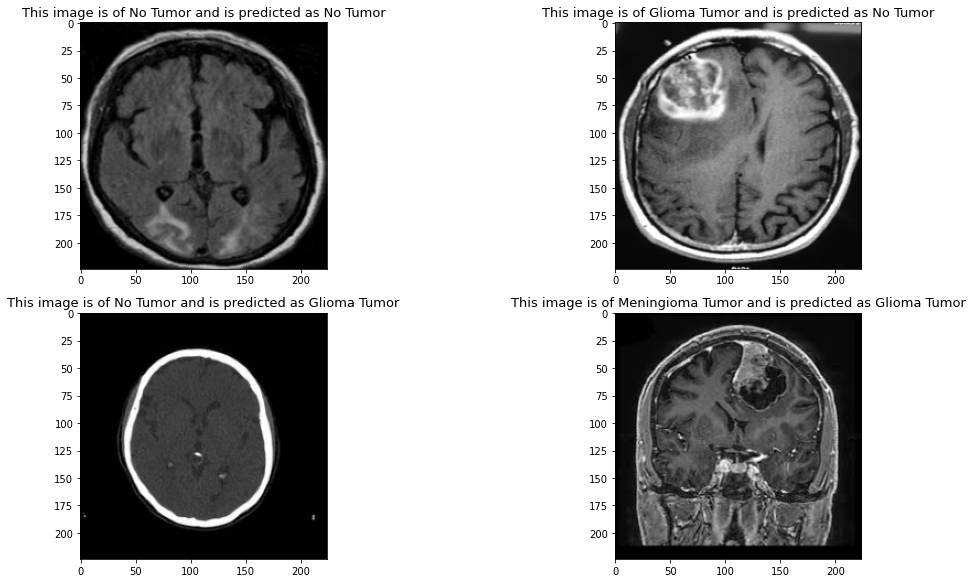

In [59]:
# Prediction using VGG16 model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_vgg.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

**Prediction using EfficientNetB0**

In [60]:
train_pred = model_eff.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 99.46%


In [61]:
test_pred = model_eff.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 74.37%


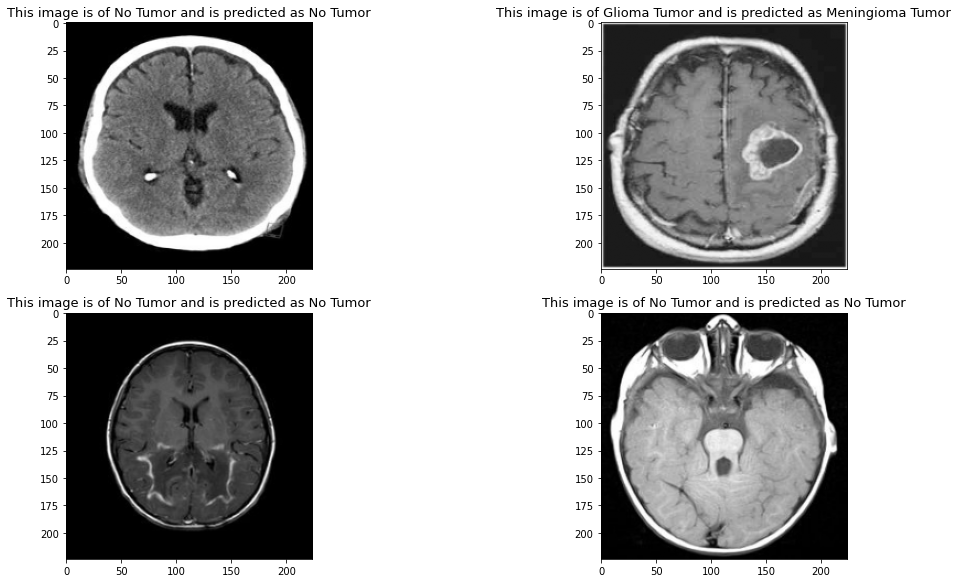

In [62]:
# Prediction using EfficientNetB0 model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_eff.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

# Conclusion

In this notebook, I performed Image Classification (Brain tumor MRI images) with the help of CNN and Transfer Learning on VGG16 and EfficientNetB0.

>For CNN, the accuracy on training set is 99.38%, but the accuracy on testing set is 71.07%.

>For VGG16, the accuracy on training set is 97.41%, but the accuracy on testing set: 75.89%.

>For EfficientNetB0, the accuracy on training set is 99.85%, but the accuracy on testing set: 78.93%.

As you can see from the results, the Transfer Learning method gave a better performance of the model over the traditional CNN method. Instead of training a model from scratch, I can use existing architectures that have been trained on a large dataset and then tune them for my task. This reduces the time to train and often results in better overall performance in the Transfer learning process.